In [1]:
import pandas as pd
import os
import time
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Masking, LSTM, Dense

from LSTM.naive_preprocess import process_data
from LSTM.LSTM_classifier import LSTMclf
from LSTM.Config import Options as opts
from tools.tools import evaluate

#### Load and preprocess data

In [2]:
pos_train_path = os.path.join('Data', 'pos_train.csv')
pos_train = pd.read_csv(pos_train_path)

neg_train_path = os.path.join('Data', 'neg_train.csv')
neg_train = pd.read_csv(neg_train_path)

pos_test_path = os.path.join('Data', 'pos_test.csv')
pos_test = pd.read_csv(pos_test_path)

neg_test_path = os.path.join('Data', 'neg_test.csv')
neg_test = pd.read_csv(neg_test_path)

train_data, train_labels = process_data(pos_train, neg_train)
input_shape = np.array(train_data).shape
test_data, test_labels = process_data(pos_test, neg_test)

print(f'Train shape: {input_shape} Test shape: {np.array(test_data).shape}')

Train shape: (717, 500, 5) Test shape: (74, 500, 5)


#### Instantiate our model

In [3]:
clf = LSTMclf(input_shape)
clf.model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 500, 5)            0         
                                                                 
 lstm (LSTM)                 (None, 200)               164800    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 165001 (644.54 KB)
Trainable params: 165001 (644.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 5 fold CV on different batch sizes

Accumulate the results for each to compare later

In [4]:
batch_sizes = [32, 64, 128, 256]
results = []
start_time = time.time()
for batch_size in batch_sizes:
    print(f'Cross validation with batch size {batch_size}.')
    metrics = clf.trainCV(train_data, train_labels, 5, batch_size, 10)
    metrics['batch_size'] = batch_size
    results.append(metrics)

    model_path = os.path.join('./LSTM/results/naive_results', f'LSTM{batch_size}.h5')
    clf.model.save(model_path)

elapsed_time = time.time() - start_time
results_df = pd.DataFrame(results, columns=['batch_size', 'accuracy', 'precision', 
                                            'recall', 'f1', 'auc'])
hr = int(elapsed_time // 3600)
elapsed_time %= 3600
min = int(elapsed_time // 60)
sec = elapsed_time % 60
print(f'Total time: {hr:02d}:{min:02d}:{sec:0.2f}\n')

result_path = os.path.join('./LSTM/results/naive_results', 'results.csv')
results_df.to_csv(result_path)
results_df

Cross validation with batch size 32.
Beginning training LSTM with 5-fold validation...
Epoch 1/10
18/18 [==============================] - 21s 862ms/step - loss: 0.6298 - accuracy: 0.6603
Epoch 2/10
18/18 [==============================] - 13s 704ms/step - loss: 0.5812 - accuracy: 0.6864
Epoch 3/10
18/18 [==============================] - 13s 743ms/step - loss: 0.5583 - accuracy: 0.7056
Epoch 4/10
18/18 [==============================] - 14s 770ms/step - loss: 0.5455 - accuracy: 0.7352
Epoch 5/10
18/18 [==============================] - 14s 775ms/step - loss: 0.5203 - accuracy: 0.7491
Epoch 6/10
18/18 [==============================] - 13s 699ms/step - loss: 0.5008 - accuracy: 0.7509
Epoch 7/10
18/18 [==============================] - 13s 714ms/step - loss: 0.4934 - accuracy: 0.7753
Epoch 8/10
18/18 [==============================] - 15s 844ms/step - loss: 0.4689 - accuracy: 0.7840
Epoch 9/10
18/18 [==============================] - 15s 820ms/step - loss: 0.4770 - accuracy: 0.7805
Epoc

#### Reload the model that looks best and evaluate against our held out test data

              precision    recall  f1-score   support

           0       0.97      0.81      0.88        37
           1       0.84      0.97      0.90        37

    accuracy                           0.89        74
   macro avg       0.90      0.89      0.89        74
weighted avg       0.90      0.89      0.89        74



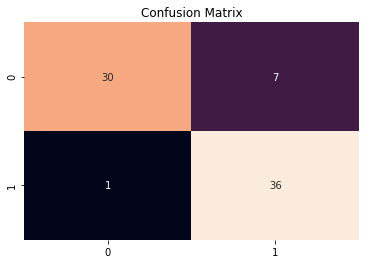

In [5]:
model_path = os.path.join('./LSTM/results/naive_results', 'LSTM128.h5')
clf = load_model(model_path, compile=False)

pred = clf.predict(test_data).reshape(-1)
pred = (pred > 0.5).astype(int)
metrics = evaluate(test_labels, pred)

print(classification_report(test_labels, pred))
cm = confusion_matrix(test_labels, pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.show()

In [6]:
json_path = os.path.join('./LSTM/results/naive_results', 'metrics.json')
with open(json_path, 'w') as FP:
    json.dump(metrics, FP)